# Projekt "Kamień, Papier, Nożyce"
Klasyfikacja gestów “Kamień, Papier, Nożyce” na podstawie zdjęć dłoni.

Zaimportowanie niezbędnych pakietów

In [77]:
from skimage import io
import skimage.filters as sif
import numpy as np
import pandas as pd
import skimage.measure as sime
import seaborn as sns

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.ndimage.morphology as holes

from os import listdir
from os.path import isfile, join

# Obróbka obrazów
Zdjęcia dłoni na zielonym tle modyfikujemy na obraz binarny:
 - rozmywamy obraz przy użyciu filtra Gaussa,
 - przy wykorzystaniu metody opierającej się o intensywność kanału czerwonego RGB oddzielamy kształt dłoni od tła, 
 - przycinamy obraz do bounding boxa kształtu dłoni,
 - wycinamy pozostałą część ramienia poza dłonią obliczając dla każdego wiersza średnią wartość pikseli 
  

In [78]:
#metody pomocnicze

# załadowanie i obracanie odpowiednio obraz spod danej ścieżki
def load_img(path):
    img = io.imread(path)

    return np.rot90(img, 3)

# rozmywanie obrazu
def blur_img(img):
    return sif.gaussian(img, 5, multichannel = True)

# tworzenie maski na podstawie intensywności kanału czerwonego
def color_mask(img):
    return img[:,:,0] > 0.4

# utworzenie obrazu binarnego (oddzielenia tła od kształtu dłoni: tło - czarne, dłoń - białe)
def binarize(img):
    bin_img = color_mask(img)
    holes.binary_fill_holes(bin_img).astype(int)

    return bin_img

# znalezienie bbox-a całego obrazu
def find_entire_bbox(bin_img):
    columns = np.any(bin_img, axis=0)
    left = np.argmax(columns)
    right = bin_img.shape[1] - np.argmax(np.flipud(columns)) - 1
    
    rows = np.any(bin_img, axis=1)
    top = np.argmax(rows)
    bottom = bin_img.shape[0] - np.argmax(np.flipud(rows)) - 1

    return top, left, bottom, right

# przycięcie zdjęcia do postaci bounding boxa dłoni
def crop_bin_img(bin_img):
    top, left, bottom, right = find_entire_bbox(bin_img)
    return bin_img[top:bottom, left:right]

# obliczenie średniej jasności każdego wersu obrazu
def calculate_row_means(bin_img):
    return np.apply_along_axis(np.mean, 1, bin_img)

# przycinanie ramienia, aby jak największą część obrazu stanowiła sama dłoń
def crop_hand(bin_img, row_means, threshold):
    rm_threshold = row_means > threshold
    last_row = len(rm_threshold) - np.argmax(rm_threshold[::-1]) - 1

    return bin_img[:last_row,::]

In [79]:
# całościowa obróbka obrazu
def prepare_img(img):
    bin_img = binarize(blur_img(img))
    cropped_img = crop_bin_img(bin_img)
    row_means = calculate_row_means(cropped_img)

    return crop_hand(cropped_img, row_means, 0.7)

Proces przygotowania obrazu krok po kroku, testowanie działania pojedynczych metod

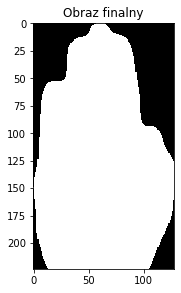

In [80]:
plt.figure(figsize=(12, 5))

img = load_img("paper/0a3UtNzl5Ll3sq8K.png")
plt.subplot(1, 4, 1)
io.imshow(img)
plt.title("Obraz wejściowy")

bimg = blur_img(img)
plt.subplot(1, 4, 2)
io.imshow(bimg)
plt.title("Obraz rozmyty")

bin_img = binarize(bimg)
plt.subplot(1, 4, 3)
io.imshow(bin_img)
plt.title("Obraz binarny")

cropped_img = crop_bin_img(bin_img)
plt.subplot(1, 4, 4)
io.imshow(cropped_img)
plt.title("Przycięcie do BBOX")
plt.show()

row_means = calculate_row_means(cropped_img)

plt.plot(row_means)
plt.plot(row_means > 0.7)
plt.title("Średnie wartości wierszy obrazu i granice drugiego przycięcia")
plt.show()

cropped_img = crop_hand(cropped_img, row_means, 0.7)
io.imshow(cropped_img)
plt.title("Obraz finalny")
plt.show()

(174, 131)
(224, 128)
(113, 149)
(209, 90)


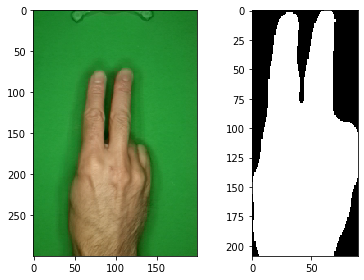

In [81]:
# Binaryzacja przykładowych obrazów
images = ["rock/bu8W5hPRULeRi0Kr.png", "paper/0a3UtNzl5Ll3sq8K.png", "rock/fnIIkyRgH6znwmNp.png", "scissors/mBHQsHWDcRvtLIKC.png"]

plt.figure(figsize=(10, 7))

for i, path in enumerate(images):
    img = load_img(path)
    bin_img = prepare_img(img)
    print(bin_img.shape)

    plt.subplot(1, 2, 1)
    io.imshow(img)

    plt.subplot(1, 2, 2)
    io.imshow(bin_img)

    plt.show()

# Ekstrakcja cech
Dla każdego obrazu obliczamy następujące atrybuty:
 - Współczynnik proporcji,
 - Względna “jasność” górnej części obrazu
 - Średnia wartość wiersza w połowie górnej części obrazu
 - Liczba segmentów górnej ćwierci obrazu 
 - średnie pole segmentów górnej ćwierci obrazu 
  

In [82]:
# metody pomocnicze

# dzielenie obrazu linią poziomą na 2 równe części
def bisect_img(img):
    y_knife = int(img.shape[0] / 2)

    return (img[:y_knife,::], img[y_knife:,::])

# obliczanie współczynnika proporcji
def calculate_aspect_ratio(img):
    return img.shape[0] / img.shape[1]

# obliczanie średniej wartość wiersza w połowie górnej części obrazu
def calculate_halfway_top_mean(top_img, row_means):
    return row_means[int(top_img.shape[0] / 2)]

#obliczanie ilości segmentów górnej ćwierci obrazu oraz ich średniego pola
def calculate_finger_segment_stats(top_img):
    qtop_img = top_img[:int(top_img.shape[0] / 2),::]

    labels = sime.label(qtop_img)
    rprops_table = sime.regionprops_table(labels, properties=["area"])

    return labels.max(), rprops_table["area"].mean()

# obliczanie względnej jasności górnej połowy obrazu względem dolnej części
def calculate_top_mean(top_img, bottom_img):
    return top_img.mean() / bottom_img.mean()

In [83]:
# obliczane atrybutów obrazu 
def calculate_attributes(cropped_bin_img):
    row_means = calculate_row_means(cropped_bin_img)
    shape_ratio = calculate_aspect_ratio(cropped_bin_img)

    top_img, bottom_img = bisect_img(cropped_bin_img)
    ti_mean = calculate_top_mean(top_img, bottom_img)
    hf_mean = calculate_halfway_top_mean(top_img, row_means)
    qsegcount, qsegarea = calculate_finger_segment_stats(top_img)

    return shape_ratio, ti_mean, hf_mean, qsegcount, qsegarea

In [84]:
# zebranie danych dotyczących obrazu
def create_data_point(path, pose):
    img = load_img(path)
    cropped_img = prepare_img(img)

    ar, tbrtb, thrm, fsc, fsta = calculate_attributes(cropped_img)

    return {
        "aspectRatio": ar,
        "topBrightnessRelativeToBottom": tbrtb,
        "topHalfwayRowMean": thrm,
        "fingerSegmentCount": fsc,
        "fingerSegmentMeanArea": fsta,
        "pose": pose
    }

# wczytanie obrazów z pojedynczego folderu
def get_files_in_dir(dirpath):
    return [f for f in listdir(dirpath) if isfile(join(dirpath, f))]

# wczytanie obrazów z folderów
def load_images(poses=["paper", "rock", "scissors"]):
    items = []

    for dirpath in poses:
        images = get_files_in_dir(dirpath)

        for f in images:
            items.append(create_data_point(join(dirpath, f), dirpath))
            print("{} done!".format(join(dirpath, f)))

    return items

In [85]:
# ładowanie wszystkich obrazów
data_points = load_images()

paper/dDtRH0QF7IPSsasH.png done!
paper/7ZGsbIMypDIEZxR0.png done!
paper/HTSIUeIA1IQrHtHu.png done!
paper/wytuIz48uLeDoGqz.png done!
paper/LhgH8QOKfA5xu287.png done!
paper/LYirpnRmbCGN6T7O.png done!
paper/yB11HwUEuYHhVlKo.png done!
paper/7w91NsCtVzsPOSYB.png done!
paper/Ea6A81oe4Ria2MW3.png done!
paper/s4dtRIGK3emNyjrO.png done!
paper/7UoLr02FuYuLrJxz.png done!
paper/ZGQV7rFVePreAdOe.png done!
paper/CwFaCN3ykqwQ6KZV.png done!
paper/Y8kfG3f6KJa1YJPA.png done!
paper/RFXW2X1DlH7xboth.png done!
paper/eiiwN1DsKoIheMgz.png done!
paper/eW9ezZkV7Jxu1BEk.png done!
paper/WVfwcOw6nXcg4xER.png done!
paper/Uok6jb9ObZxSWCDu.png done!
paper/kmBByXdkwf5Vro8P.png done!
paper/6BIKQpfZEfQkCvrz.png done!
paper/R7y8PxDKzaAd0uUQ.png done!
paper/k9d5xaurp8JC9DXp.png done!
paper/9WQaDoiIDC4zGPr8.png done!
paper/OMq2VJyb0KwtdwDc.png done!
paper/cOHWfHkyo8sqWnpW.png done!
paper/RmTijOM3U31zKnrY.png done!
paper/LkNkNVjTRm5Gr9NQ.png done!
paper/sZyZICXHv0ArIZFw.png done!
paper/ib30bLCbBl0mKWko.png done!
paper/PDV8

In [86]:
# utworzenie ramki danych z obliczonymi atrybutami dla każdego obrazu
df = pd.DataFrame(columns=[
        "aspectRatio",
        "topBrightnessRelativeToBottom",
        "topHalfwayRowMean",
        "fingerSegmentCount",
        "fingerSegmentMeanArea",
        "pose"
    ]
).astype("float")

df = df.append(data_points, ignore_index=True)
df_orig = df

df

,aspectRatio,topBrightnessRelativeToBottom,topHalfwayRowMean,fingerSegmentCount,fingerSegmentMeanArea,pose
0,1.437500,0.582808,0.618056,1.0,2883.0,paper
1,1.254438,0.584757,0.473373,2.0,1575.0,paper
2,1.728814,0.675038,0.686441,1.0,2712.0,paper
3,1.752000,0.656261,0.680000,1.0,2956.0,paper
4,1.950000,0.771700,0.850000,1.0,2539.0,paper
...,...,...,...,...,...,...
2183,2.255319,0.485994,0.457447,2.0,895.5,scissors
2184,1.838983,0.535166,0.457627,2.0,1121.5,scissors
2185,2.057851,0.535677,0.388430,2.0,1050.5,scissors
2186,2.459184,0.584324,0.500000,2.0,1240.5,scissors


# Analiza przydatności atrybutów
Ocena użyteczności i korelacji poszczególnych atrybutów na podstwie macierzy korelacji oraz macierzy wykresów punktowych

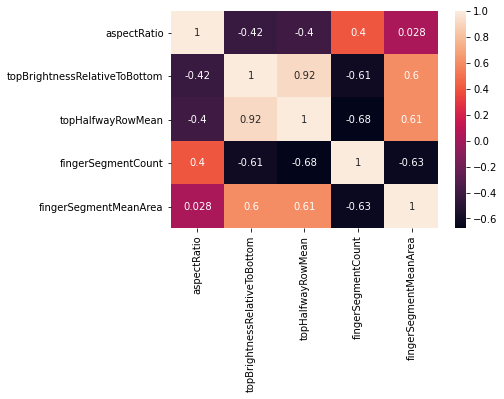

In [87]:
# macierz korelacji
df_no_y = df.drop(columns=["pose"])
corr = df_no_y.corr()

sns.heatmap(corr, annot=corr)
plt.show()

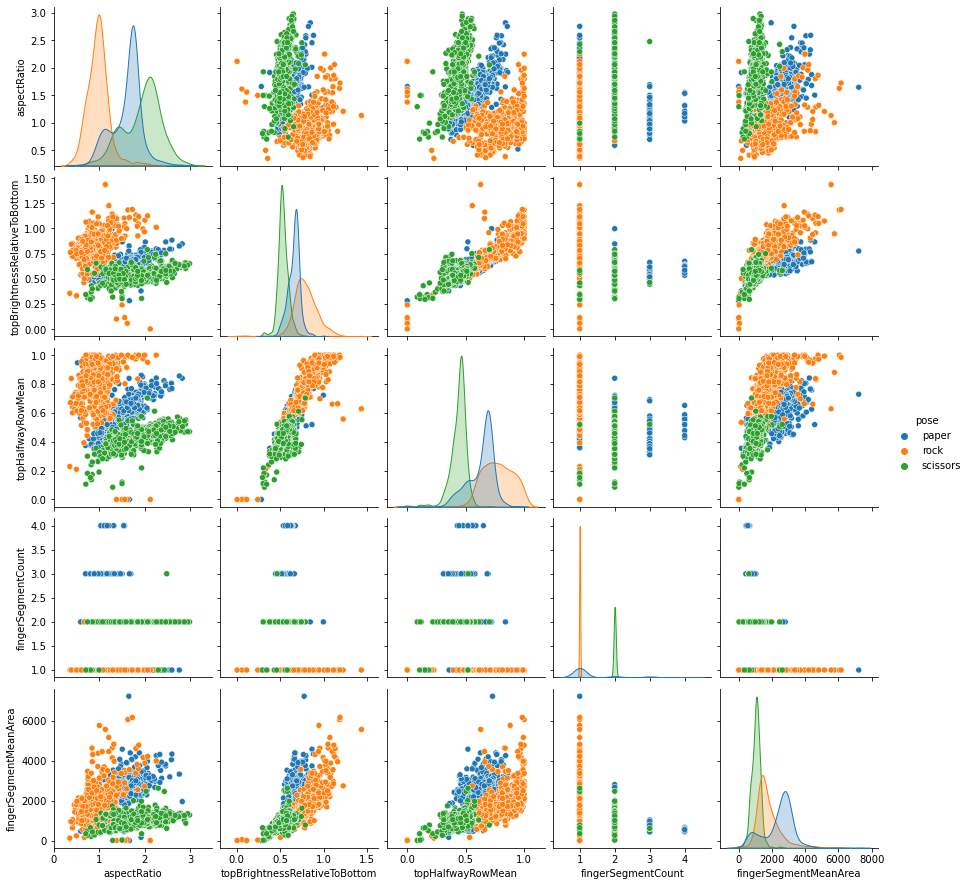

In [88]:
#macierz wykresów punktowych dla danych atrybutów
sns.pairplot(df, kind="scatter", hue="pose")
plt.show()

In [89]:
# usunięcie fingerSegmentCount na podstawie analizy użyteczności atrybutu
df = df.drop(columns=["fingerSegmentCount"])
df

,aspectRatio,topBrightnessRelativeToBottom,topHalfwayRowMean,fingerSegmentMeanArea,pose
0,1.437500,0.582808,0.618056,2883.0,paper
1,1.254438,0.584757,0.473373,1575.0,paper
2,1.728814,0.675038,0.686441,2712.0,paper
3,1.752000,0.656261,0.680000,2956.0,paper
4,1.950000,0.771700,0.850000,2539.0,paper
...,...,...,...,...,...
2183,2.255319,0.485994,0.457447,895.5,scissors
2184,1.838983,0.535166,0.457627,1121.5,scissors
2185,2.057851,0.535677,0.388430,1050.5,scissors
2186,2.459184,0.584324,0.500000,1240.5,scissors


# Klasyfikacja
Dla danego zbioru danych, najlepszym sposobem klasyfikacji jest uczenie nadzorowane. Dlatego też zbiór najpierw został podzielony na dane uczące i testowe.
Następnie, dla porównania użyte zostaną następujące klasyfikatory z optymalnie dobranymi parametrami:
- k-Najbliższych sąsiadów (k-NN)
- Najbliższego prototypu
- Naiwny klasyfikator Bayesa
- Drzewo decyzyjne (DT)

In [98]:
# podział danych na zbiór uczący i testowy
df_x = df.drop(columns=["pose"])
df_y = df.pose

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y)

print(len(df_train_x), len(df_test_x))
df_test_x

1641 547


,aspectRatio,topBrightnessRelativeToBottom,topHalfwayRowMean,fingerSegmentMeanArea
1167,0.880342,0.854677,0.905983,1460.0
2163,1.990826,0.500959,0.449541,1007.5
301,1.500000,0.654189,0.634328,2731.0
187,1.760684,0.653537,0.666667,2530.0
2062,2.018018,0.542895,0.495495,1389.0
...,...,...,...,...
718,0.914729,0.716102,0.728682,1187.0
1025,1.169492,0.625324,0.610169,1353.0
272,1.714286,0.658556,0.674603,2917.0
1425,0.838710,1.008243,0.935484,2381.0


## Dobór parametrów klasyfikatorów
Przed porównaniem klasyfikatorów między sobą, najpierw zostały dobrane optymalne parametry dla każdego z nich.

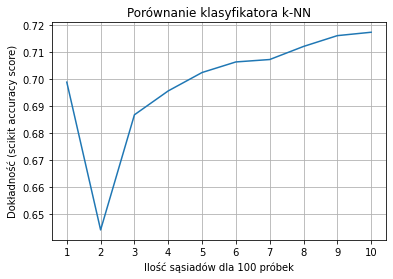

In [91]:
# dobór parametru k dla metody k-NN
ns = list(range(1, 11))
acc_averages = []
samples = 100

for n in ns:
    model = KNeighborsClassifier(n_neighbors=n)
    acc_avg = 0

    for i in range(0, samples):
        df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y)
        model.fit(df_train_x, df_train_y)
        result_test = model.predict(df_test_x)

        acc_avg += metrics.accuracy_score(df_test_y, result_test) / samples
    
    acc_averages.append(acc_avg)

plt.title("Porównanie klasyfikatora k-NN")
plt.xlabel("Ilość sąsiadów dla {} próbek".format(samples))
plt.ylabel("Dokładność (scikit accuracy score)")
plt.xticks(np.arange(1, 11, step=1))
plt.grid(True)

plt.plot(ns, acc_averages)
plt.show()

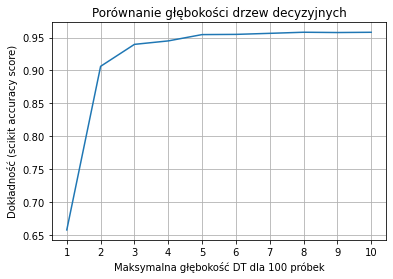

In [92]:
# dobór głębokości drzewa dla metody drzewa decyzyjnego
ns = list(range(1, 11))
acc_averages = []
samples = 100

for n in ns:
    model = DecisionTreeClassifier(max_depth=n)
    acc_avg = 0

    for i in range(0, samples):
        df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y)
        model.fit(df_train_x, df_train_y)
        result_test = model.predict(df_test_x)

        acc_avg += metrics.accuracy_score(df_test_y, result_test) / samples
    
    acc_averages.append(acc_avg)

plt.title("Porównanie głębokości drzew decyzyjnych")
plt.xlabel("Maksymalna głębokość DT dla {} próbek".format(samples))
plt.ylabel("Dokładność (scikit accuracy score)")
plt.xticks(np.arange(1, 11, step=1))
plt.grid(True)

plt.plot(ns, acc_averages)
plt.show()

## Wyniki klasyfikacji
Na podstawie wcześniejszej analizy dobrano parametry klasyfikatorów i wybrano ostateczne modele:
- k-Najbliższych sąsiadów (k-NN) dla k=9
- Najbliższego prototypu
- Naiwny klasyfikator Bayesa
- Drzewo decyzyjne (DT) dla parametru głębokość=5

In [93]:
# ostateczne klasyfikatory uczenia nadzorowanego 
models = [
    ("9-Najbliższych sąsiadów", KNeighborsClassifier(n_neighbors=9)),
    ("Najbliższego prototypu", NearestCentroid()),
    ("Naiwny Bayesa", GaussianNB()),
    ("Drzewo decyzyjne o głębokości 5", DecisionTreeClassifier(max_depth=5)),
]

In [94]:
# zbadanie dokładności dla 100 prób dla każdego klasyfikatora
samples = 100

for i, model in enumerate(models):
    avg_acc_score = 0
    for j in range(0, samples):
        df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y)
        model[1].fit(df_train_x, df_train_y)
        result_test = model[1].predict(df_test_x)

        avg_acc_score += metrics.accuracy_score(df_test_y, result_test) / samples
    
    print("Dokładność dla {}: {}".format(model[0], avg_acc_score))

Dokładność dla 9-Najbliższych sąsiadów: 0.7174771480804389
Dokładność dla Najbliższego prototypu: 0.7053564899451555
Dokładność dla Naiwny Bayesa: 0.9204204753199271
Dokładność dla Drzewo decyzyjne o głębokości 5: 0.9526508226691044



9-Najbliższych sąsiadów

 MACIERZ POMYŁEK DLA ZBIORU UCZĄCEGO
          paper  rock  scissors
                               
paper       382    68        76
rock         89   352        94
scissors      9    67       504
 | | | | | | | |
 v v v v v v v v
OCENA DOKŁADNOŚCI:
0.7544180377818404

 MACIERZ POMYŁEK DLA ZBIORU TESTOWEGO
          paper  rock  scissors
                               
paper       135    28        23
rock         27   123        41
scissors      3    24       143
 | | | | | | | |
 v v v v v v v v
OCENA DOKŁADNOŚCI:
0.7330895795246801
-----------------------------------

Najbliższego prototypu

 MACIERZ POMYŁEK DLA ZBIORU UCZĄCEGO
          paper  rock  scissors
                               
paper       382    47        97
rock        134   216       185
scissors      2    25       553
 | | | | | | | |
 v v v v v v v v
OCENA DOKŁADNOŚCI:
0.7014015843997562

 MACIERZ POMYŁEK DLA ZBIORU TESTOWEGO
          paper  rock  scissors
                               
p

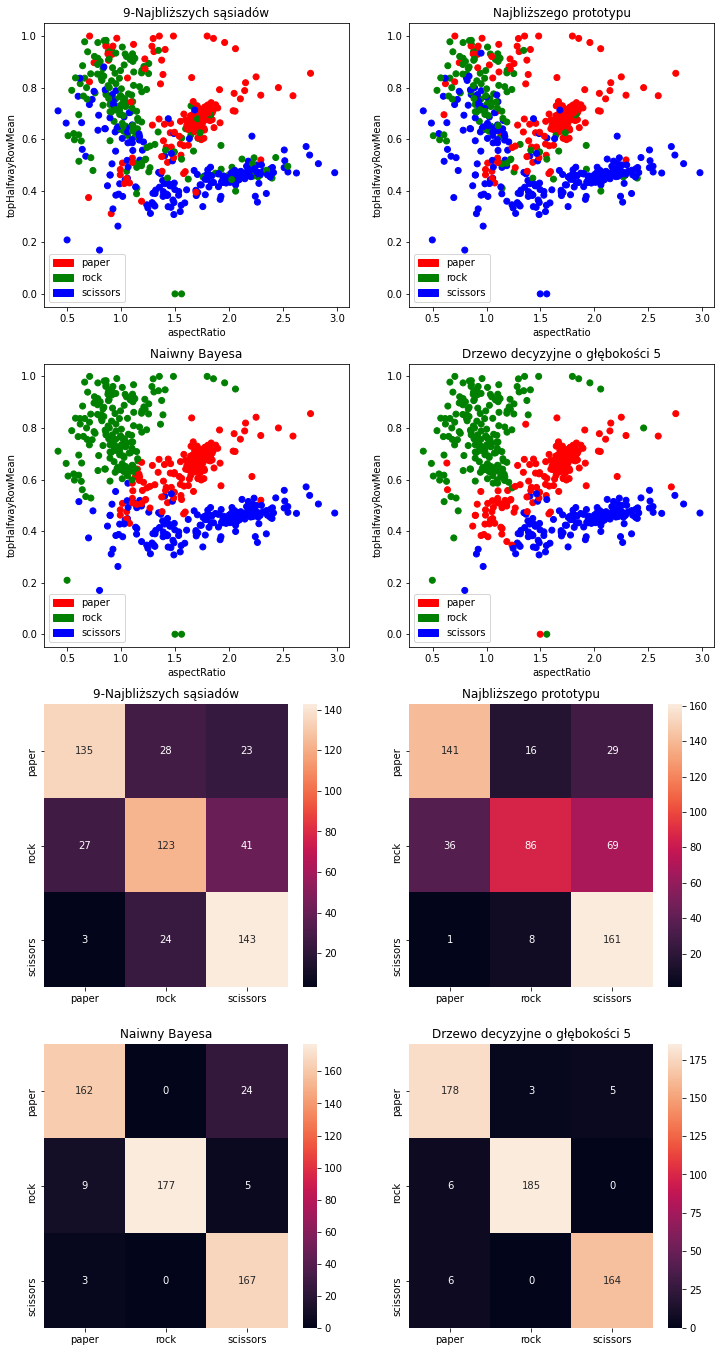

In [95]:
# utworzenie wykresów punktowych i macierzy pomyłek dla każdego klasyfikatora
colors = {
    "paper": "red",
    "rock": "green",
    "scissors": "blue"
}
result_test_colors = list(map(
    lambda x: colors[x],
    df_test_y.tolist()
))

plt.figure(figsize=(6, 6))
plt.xlabel("aspectRatio")
plt.ylabel("topHalfwayRowMean")
plt.title("Dane pierwotne")
plt.scatter(df_test_x["aspectRatio"] , df_test_x["topHalfwayRowMean"], c=result_test_colors, label = result_test_colors)
red_patch = mpatches.Patch(color="red", label="paper")
green_patch = mpatches.Patch(color="green", label="rock")
blue_patch = mpatches.Patch(color="blue", label="scissors")
plt.legend(handles=[red_patch, green_patch, blue_patch])

plt.figure(figsize=(12, 24))
for i, model in enumerate(models):
    print("\n{}".format(model[0]))

    model[1].fit(df_train_x, df_train_y)

    result_train = model[1].predict(df_train_x)
    result_test = model[1].predict(df_test_x)

    result_train_colors = list(map(
        lambda x: colors[x],
        result_train.tolist()
    ))
    result_test_colors = list(map(
        lambda x: colors[x],
        result_test.tolist()
    ))

    test_mistake_mx = pd.crosstab(df_test_y, result_test)
    test_mistake_mx.columns.name = None
    test_mistake_mx.index.names = [""]

    train_mistake_mx = pd.crosstab(df_train_y, result_train)
    train_mistake_mx.columns.name = None
    train_mistake_mx.index.names = [""]

    plt.subplot(4, 2, i + 1)
    plt.xlabel("aspectRatio")
    plt.ylabel("topHalfwayRowMean")
    plt.title(model[0])
    plt.scatter(df_test_x["aspectRatio"] , df_test_x["topHalfwayRowMean"], c=result_test_colors, label = result_test_colors)

    red_patch = mpatches.Patch(color="red", label="paper")
    green_patch = mpatches.Patch(color="green", label="rock")
    blue_patch = mpatches.Patch(color="blue", label="scissors")
    plt.legend(handles=[red_patch, green_patch, blue_patch])


    plt.subplot(4, 2, i + 5)
    plt.title(model[0])
    sns.heatmap(test_mistake_mx, annot=test_mistake_mx, fmt="g")
    
    
    print("\n MACIERZ POMYŁEK DLA ZBIORU UCZĄCEGO")
    print(train_mistake_mx)
    print(" |" * 8)
    print(" v" * 8)
    print("OCENA DOKŁADNOŚCI:")
    print(metrics.accuracy_score(df_train_y, result_train))
    print("\n MACIERZ POMYŁEK DLA ZBIORU TESTOWEGO")
    print(test_mistake_mx)
    print(" |" * 8)
    print(" v" * 8)
    print("OCENA DOKŁADNOŚCI:")
    print(metrics.accuracy_score(df_test_y, result_test))
    print("-" * 35)

plt.show()

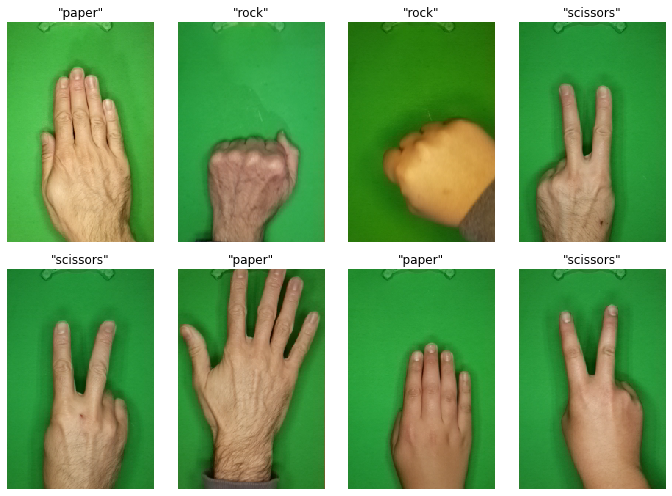

In [101]:
# przykład klasyfikacji
model = DecisionTreeClassifier(max_depth=5)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y)
model.fit(df_train_x, df_train_y)

images = [
    "paper/7fRLxoheLluOwCkp.png",
    "rock/BvjXvNTvapIFq4bK.png",
    "rock/fnIIkyRgH6znwmNp.png",
    "scissors/jy6fSFQ1ynecl3P7.png",
    "scissors/uU7I4uUVN2mDwZpo.png",
    "paper/9Dto1OCNf5wjYimE.png",
    "paper/LhgH8QOKfA5xu287.png",
    "scissors/4X8TOCQTfCWnMfm2.png"
]

plt.figure(figsize=(10, 7))

for i, path in enumerate(images):
    img = load_img(path)
    dp = create_data_point(path, None)
    dp_df = pd.DataFrame().append(dp, ignore_index=True).drop(columns=["pose", "fingerSegmentCount"])

    predicted_pose = model.predict(dp_df)[0]

    plt.subplot(2, 4, i + 1)
    plt.axis("off")
    plt.title("\"{}\"".format(predicted_pose))
    io.imshow(img)

plt.show()